In [1]:
import pandas as pd
import pandahouse as ph
import seaborn as sns

In [2]:
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator'
}

q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr

FROM simulator_20230120.feed_actions
WHERE toDate(time) between '2022-12-25' and '2022-12-31'
    and exp_group in (2,3)
GROUP BY exp_group, user_id"""

# Вытащили пользователей
users_df = ph.read_clickhouse(q, connection=connection)


In [3]:
users_df.head()

,exp_group,user_id,likes,views,ctr
0,3,115383,11,36,0.305556
1,3,123580,15,92,0.163043
2,2,131473,26,148,0.175676
3,2,23985,12,66,0.181818
4,2,24523,17,120,0.141667


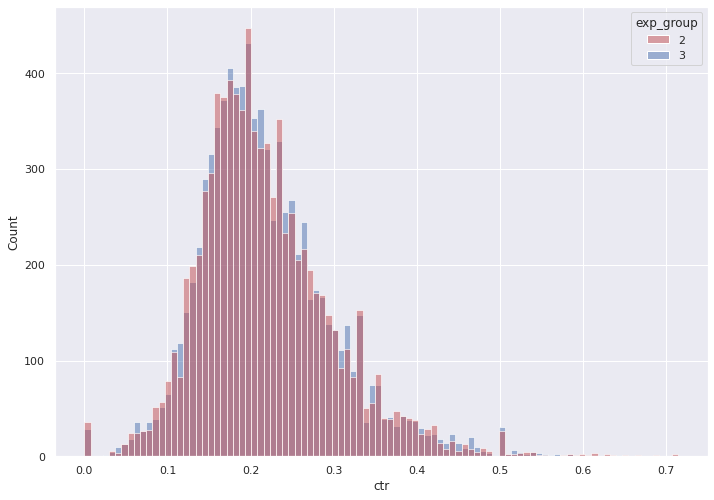

In [4]:
# Сделаем графики в seaborn покрупнее
sns.set(rc={'figure.figsize':(11.7,8.27)})

groups = sns.histplot(data = users_df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

In [5]:
df_pvalue = pd.DataFrame(columns =  ["stat", "pval"])
import scipy.stats as stats

number_of_tests = 10000 

for i in range(number_of_tests):
    statistic, pvalue = stats.ttest_ind(users_df[users_df.exp_group == 2].sample(500).ctr,
                    users_df[users_df.exp_group == 3].sample(500).ctr,
                    alternative='two-sided',
                    equal_var=False)
    df_pvalue.loc[i] = [statistic, pvalue]

In [6]:
df_pvalue.head()

,stat,pval
0,-1.058066,0.290282
1,-0.778233,0.436617
2,-1.402359,0.161119
3,-1.831383,0.067342
4,0.199100,0.842226


<AxesSubplot:xlabel='pval', ylabel='Count'>

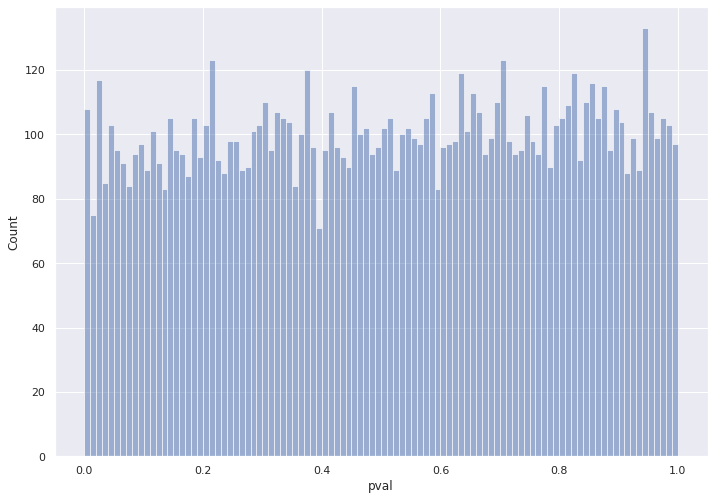

In [10]:
# Сделаем графики в seaborn покрупнее
sns.set(rc={'figure.figsize':(11.7,8.27)})

sns.histplot(data = df_pvalue, 
              x='pval', bins=100,
              palette = ['b'],
              alpha=0.5,
              kde=False)

In [8]:
# какой процент p values оказался меньше либо равен 0.05
100 *(df_pvalue[df_pvalue.pval <= 0.05].shape[0] / number_of_tests)

4.88

Так как мы получили  меньше пяти процентов случаев p-value больше 0,05 а наши разбивки не подразумевают никаких значимых отличий в значения
то ошибка находится в пределах случайности и наша система сплитования работает корректно